In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import Adam
from torch.optim.lr_scheduler import LambdaLR
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import MNIST
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm,trange
from einops import rearrange
import functools

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor,
    transforms.Normdalize((-0.5,),(-0.5,))
])

In [4]:
mnist = MNIST(root='./data',
                 train=True,
                 transform=transform,
                 download=True)

data_loader = DataLoader(dataset='mnist',
                         batch_size=200,
                         shuffle=True)

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Ongoing Device : {device}')

Ongoing Device : cuda


In [6]:
class Dense(nn.Module):
    def __init__(self,input_size,output_size):
        super(Dense,self).__init__()
        self.dense = nn.Linear(input_size,output_size)
    
    def forward(self,x):
        return self.dense(x)[..., None, None]

In [7]:
def marginal_prob_std(t, sigma):
    t = t.to(device)
    return torch.sqrt((sigma**(2 * t) - 1.) / 2. / np.log(sigma))

In [8]:
def diffusion_coeff(t, sigma):
    return sigma**t.to(device)

In [9]:
def loss_fn_cond(model, x, y, marginal_prob_std, eps=1e-5):
    """
    Computes the loss for a conditional denoising diffusion probabilistic model (DDPM).

    Args:
        model: The neural network model that predicts the score (i.e., the gradient of the log probability).
        x (torch.Tensor): The original data samples (e.g., images) with shape (batch_size, channels, height, width).
        y (torch.Tensor): The conditional information (e.g., class labels or other auxiliary data).
        marginal_prob_std (function): A function that returns the standard deviation of the noise at a given time step.
        eps (float, optional): A small value to ensure numerical stability. Default is 1e-5.

    Returns:
        torch.Tensor: The computed loss as a scalar tensor.
    """
    
    # Sample a random time step for each sample in the batch.
    random_t = torch.rand(x.shape[0], device=x.device) * (1. - eps) + eps
    
    # Sample random noise from a standard normal distribution with the same shape as the input.
    z = torch.randn_like(x)
    
    # Compute the standard deviation of the noise at the sampled time step.
    std = marginal_prob_std(random_t)
    
    # Perturb the input data with the sampled noise, scaled by the computed standard deviation.
    perturbed_x = x + z * std[:, None, None, None]
    
    # Predict the score (denoising direction) using the model.
    # The model takes the perturbed data, the time step, and the conditional information as inputs.
    score = model(perturbed_x, random_t, y=y)
    
    # Compute the loss as the mean squared error between the predicted score and the true noise,
    # weighted by the standard deviation.
    #loss = torch.mean(torch.sum((score * std[:, None, None, None] - z)**2, dim=(1,2,3)))
    loss = F.mse_loss(score * std[:, None, None, None], -z, reduction='mean')
    
    return loss


In [23]:
def train_diffusion_model(dataset,
                          score_model,
                          marginal_prob_std_fn,
                          n_epochs =   100,
                          batch_size =  1024,
                          lr=10e-4,
                          model_name="transformer"):
    # Print model architecture size
    total_params = sum(p.numel() for p in score_model.parameters())
    trainable_params = sum(p.numel() for p in score_model.parameters() if p.requires_grad)
    
    print(f"Model: {model_name}")
    print(f"Total parameters: {total_params:,}")
    print(f"Trainable parameters: {trainable_params:,}")
    print(f"Non-trainable parameters: {total_params - trainable_params:,}")
    print("-----------------------------")

    data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=4)

    optimizer = Adam(score_model.parameters(), lr=lr)
    scheduler = LambdaLR(optimizer, lr_lambda=lambda epoch: max(0.2, 0.98 ** epoch))
    tqdm_epoch = trange(n_epochs)
    for epoch in tqdm(tqdm_epoch):
        avg_loss = 0.
        num_items = 0
        for x, y in tqdm(data_loader):
            x = x.to(device)
            # if "ldm" in model_name:
            #     loss = loss_fn_cond_ldm(score_model, x, y, marginal_prob_std_fn)
            # else:
            loss = loss_fn_cond(score_model, x, y, marginal_prob_std_fn)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            avg_loss += loss.item() * x.shape[0]
            num_items += x.shape[0]
        if epoch % 10 == 0:
            print(f"Epoch: {epoch}, Loss: {loss:5f}")
        if epoch % 50 == 0:
            torch.save(score_model.state_dict(), f'ckpt_{epoch}.pth')

    scheduler.step()
    lr_current = scheduler.get_last_lr()[0]
    print('{} Average Loss: {:5f} lr {:.1e}'.format(epoch, avg_loss / num_items, lr_current))
    # Print the averaged training loss so far.
    tqdm_epoch.set_description('Average Loss: {:5f}'.format(avg_loss / num_items))
    # Update the checkpoint after each epoch of training.
    torch.save(score_model.state_dict(), f'ckpt_{model_name}.pth')

In [11]:
class GaussianFourierProjection(nn.Module):
    def __init__(self, embed_dim, scale=30.):
        super().__init__()
        self.W = nn.Parameter(torch.randn(embed_dim // 2) * scale, requires_grad=False)
    
    def forward(self, x):
        x_proj = x[:, None] * self.W[None, :] * 2 * np.pi
        return torch.cat([torch.sin(x_proj), torch.cos(x_proj)], dim=-1)

In [12]:
class CrossAttention(nn.Module):
    def __init__(self, embed_dim, hidden_dim, context_dim=None, num_heads=1):
        super(CrossAttention, self).__init__()
        self.hidden_dim = hidden_dim
        self.context_dim = context_dim
        self.embed_dim = embed_dim
        self.query = nn.Linear(hidden_dim, embed_dim, bias=False)
        if context_dim is None:
            self.self_attn = True
            self.key = nn.Linear(hidden_dim, embed_dim, bias=False)
            self.value = nn.Linear(hidden_dim, hidden_dim, bias=False)
        else:
            self.self_attn = False
            self.key = nn.Linear(context_dim, embed_dim, bias=False)
            self.value = nn.Linear(context_dim, hidden_dim, bias=False)

    def forward(self, tokens, context=None):
        if self.self_attn:
            Q, K, V = self.query(tokens), self.key(tokens), self.value(tokens)
        else:
            Q, K, V = self.query(tokens), self.key(context), self.value(context)
        
        scoremats = torch.einsum('bth,bsh->bts', Q, K)
        attnmats = F.softmax(scoremats, dim=1)
        ctx_vecs = torch.einsum("bts,bsh->bth", attnmats, V)
        return ctx_vecs

In [13]:
class TransformerBlock(nn.Module):
    def __init__(self, hidden_dim, context_dim):
        super(TransformerBlock, self).__init__()
        self.attn_self = CrossAttention(hidden_dim, hidden_dim)
        self.attn_cross = CrossAttention(hidden_dim, hidden_dim, context_dim)
        self.norm1 = nn.LayerNorm(hidden_dim)
        self.norm2 = nn.LayerNorm(hidden_dim)
        self.norm3 = nn.LayerNorm(hidden_dim)
        self.ffn = nn.Sequential(
            nn.Linear(hidden_dim, 4*hidden_dim),
            nn.GELU(),
            nn.Linear(4*hidden_dim, hidden_dim),
            nn.GELU()
        )

    def forward(self, x, context=None):
        x = self.attn_self(self.norm1(x)) + x
        x = self.attn_cross(self.norm2(x), context=context) + x
        x = self.ffn(self.norm3(x)) + x
        return x

In [14]:
class SpatialTransformer(nn.Module):
    def __init__(self, hidden_dim, context_dim):
        super(SpatialTransformer, self).__init__()
        self.transformer = TransformerBlock(hidden_dim, context_dim)

    def forward(self, x, context=None):
        b, c, h, w = x.shape
        x_in = x
        x = rearrange(x, "b c h w -> b (h w) c")
        x = self.transformer(x, context)
        x = rearrange(x, 'b (h w) c -> b c h w', h=h, w=w)
        return x + x_in

In [15]:
class UNet_Tranformer(nn.Module):
    def __init__(self, marginal_prob_std, channels=[32, 64, 128, 256], embed_dim=256,
               text_dim=256, nClass=10):
        super().__init__()
        self.time_embed = nn.Sequential(
            GaussianFourierProjection(embed_dim=embed_dim),
            nn.Linear(embed_dim, embed_dim)
        )
        
        # Encoding layers
        self.conv1 = nn.Conv2d(1, channels[0], 3, stride=1, bias=False)
        self.dense1 = Dense(embed_dim, channels[0])
        self.gnorm1 = nn.GroupNorm(4, num_channels=channels[0])

        self.conv2 = nn.Conv2d(channels[0], channels[1], 3, stride=2, bias=False)
        self.dense2 = Dense(embed_dim, channels[1])
        self.gnorm2 = nn.GroupNorm(32, num_channels=channels[1])

        self.conv3 = nn.Conv2d(channels[1], channels[2], 3, stride=2, bias=False)
        self.dense3 = Dense(embed_dim, channels[2])
        self.gnorm3 = nn.GroupNorm(32, num_channels=channels[2])
        self.attn3 = SpatialTransformer(channels[2], text_dim)

        self.conv4 = nn.Conv2d(channels[2], channels[3], 3, stride=2, bias=False)
        self.dense4 = Dense(embed_dim, channels[3])
        self.gnorm4 = nn.GroupNorm(32, num_channels=channels[3])
        self.attn4 = SpatialTransformer(channels[3], text_dim)

        # Decoding layers
        self.tconv4 = nn.ConvTranspose2d(channels[3], channels[2], 3, stride=2, bias=False)
        self.dense5 = Dense(embed_dim, channels[2])
        self.tgnorm4 = nn.GroupNorm(32, num_channels=channels[2])

        self.tconv3 = nn.ConvTranspose2d(channels[2], channels[1], 3, stride=2, bias=False, output_padding=1)
        self.dense6 = Dense(embed_dim, channels[1])
        self.tgnorm3 = nn.GroupNorm(32, num_channels=channels[1])

        self.tconv2 = nn.ConvTranspose2d(channels[1], channels[0], 3, stride=2, bias=False, output_padding=1)
        self.dense7 = Dense(embed_dim, channels[0])
        self.tgnorm2 = nn.GroupNorm(32, num_channels=channels[0])
        self.tconv1 = nn.ConvTranspose2d(channels[0], 1, 3, stride=1)

        self.act = nn.SiLU()
        self.marginal_prob_std = marginal_prob_std
        self.cond_embed = nn.Embedding(nClass, text_dim)

    def forward(self, x, t, y=None):
        # Embed time and text
        embed = self.act(self.time_embed(t))
        y_embed = self.cond_embed(y).unsqueeze(1)
        
        # Encoding
        h1 = self.act(self.gnorm1(self.conv1(x) + self.dense1(embed)))
        h2 = self.act(self.gnorm2(self.conv2(h1) + self.dense2(embed)))
        h3 = self.act(self.gnorm3(self.conv3(h2) + self.dense3(embed)))
        h3 = self.attn3(h3, y_embed)
        h4 = self.act(self.gnorm4(self.conv4(h3) + self.dense4(embed)))
        h4 = self.attn4(h4, y_embed)

        # Decoding
        h = self.act(self.tgnorm4(self.tconv4(h4) + self.dense5(embed)))
        h = self.act(self.tgnorm3(self.tconv3(h + h3) + self.dense6(embed)))
        h = self.act(self.tgnorm2(self.tconv2(h + h2) + self.dense7(embed)))
        h = self.tconv1(h + h1)

        # Normalize predicted noise by std at time t
        h = h / self.marginal_prob_std(t)[:, None, None, None]
        return h

In [25]:
if __name__ == "__main__":
    sigma = 25.0
    marginal_prob_std_fn = functools.partial(marginal_prob_std, sigma=sigma)

    # Init model
    print("initialize new score model...")
    score_model = torch.nn.DataParallel(UNet_Tranformer(marginal_prob_std=marginal_prob_std_fn))
    score_model = score_model.to(device)

    # Define training params
    n_epochs = 1000
    batch_size = 500
    lr = 10e-4


    dataset = MNIST('.', train=True, transform=transforms.ToTensor(), download=True)
    data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=4)
    # Run
    train_diffusion_model(dataset,
                          score_model,
                          marginal_prob_std_fn,
                          n_epochs=n_epochs,
                          batch_size=batch_size,
                          lr=lr,
                          model_name=f"mnist_ddpm_mse_{n_epochs}e")

initialize new score model...
Model: mnist_ddpm_mse_1000e
Total parameters: 2,209,409
Trainable parameters: 2,209,281
Non-trainable parameters: 128
-----------------------------


  0%|          | 0/1000 [00:00<?, ?it/s]









































  0%|          | 1/1000 [00:09<2:40:53,  9.66s/it]

Epoch: 0, Loss: 0.233798












































  0%|          | 2/1000 [00:19<2:39:35,  9.60s/it]











































  0%|          | 3/1000 [00:28<2:39:21,  9.59s/it]











































  0%|          | 4/1000 [00:38<2:39:36,  9.61s/it]











































  0%|          | 5/1000 [00:47<2:38:50,  9.58s/it]













































  1%|          | 6/1000 [00:57<2:38:48,  9.59s/it]










































  1%|          | 7/1000 [01:07<2:39:03,  9.61s/it]



















































  1%|          | 8/1000 [01:16<2:38:47,  9.60s/it]





















































  1%|          | 9/1000 [01:26<2:39:44,  9.67s/it]

















































  1%|          | 10/1000 [01:36<2:40:35,  9.73s/it]
























































  1%|          | 11/1000 [01:46<2:41:41,  9.81s/it]

Epoch: 10, Loss: 0.044924























































  1%|          | 12/1000 [01:56<2:41:33,  9.81s/it]




















































  1%|▏         | 13/1000 [02:06<2:42:15,  9.86s/it]






















































  1%|▏         | 14/1000 [02:16<2:41:55,  9.85s/it]
















































  2%|▏         | 15/1000 [02:25<2:41:20,  9.83s/it]
























































  2%|▏         | 16/1000 [02:35<2:42:11,  9.89s/it]

























































  2%|▏         | 17/1000 [02:45<2:42:38,  9.93s/it]























































  2%|▏         | 18/1000 [02:56<2:43:19,  9.98s/it]























































  2%|▏         | 19/1000 [03:05<2:43:04,  9.97s/it]



























































  2%|▏         | 20/1000 [03:16<2:43:50, 10.03s/it]













































Epoch: 20, Loss: 0.034528






















































  2%|▏         | 22/1000 [03:36<2:42:54,  9.99s/it]





















































  2%|▏         | 23/1000 [03:45<2:42:09,  9.96s/it]






















































  2%|▏         | 24/1000 [03:56<2:43:42, 10.06s/it]




















































  2%|▎         | 25/1000 [04:06<2:42:20,  9.99s/it]
























































  3%|▎         | 26/1000 [04:16<2:42:43, 10.02s/it]




















































  3%|▎         | 27/1000 [04:26<2:42:31, 10.02s/it]

















































  3%|▎         | 28/1000 [04:36<2:41:15,  9.95s/it]






















































  3%|▎         | 29/1000 [04:45<2:41:13,  9.96s/it]






















































  3%|▎         | 30/1000 [04:55<2:40:35,  9.93s/it]





















































  3

Epoch: 30, Loss: 0.028001




















































  3%|▎         | 32/1000 [05:15<2:40:01,  9.92s/it]


















































  3%|▎         | 33/1000 [05:25<2:39:50,  9.92s/it]



















































  3%|▎         | 34/1000 [05:35<2:39:34,  9.91s/it]



















































  4%|▎         | 35/1000 [05:45<2:39:14,  9.90s/it]





















































  4%|▎         | 36/1000 [05:55<2:39:00,  9.90s/it]























































  4%|▎         | 37/1000 [06:05<2:39:07,  9.91s/it]
























































  4%|▍         | 38/1000 [06:15<2:38:41,  9.90s/it]

























































  4%|▍         | 39/1000 [06:24<2:38:42,  9.91s/it]




















































  4%|▍         | 40/1000 [06:34<2:38:20,  9.90s/it]





















































  4%

Epoch: 40, Loss: 0.024258




























































  4%|▍         | 42/1000 [06:54<2:37:23,  9.86s/it]
























































  4%|▍         | 43/1000 [07:04<2:36:43,  9.83s/it]


























































  4%|▍         | 44/1000 [07:13<2:36:07,  9.80s/it]





















































  4%|▍         | 45/1000 [07:23<2:36:19,  9.82s/it]


















































  5%|▍         | 46/1000 [07:33<2:35:56,  9.81s/it]
























































  5%|▍         | 47/1000 [07:43<2:35:30,  9.79s/it]
























































  5%|▍         | 48/1000 [07:53<2:35:46,  9.82s/it]





















































  5%|▍         | 49/1000 [08:02<2:35:20,  9.80s/it]























































  5%|▌         | 50/1000 [08:12<2:34:59,  9.79s/it]







































Epoch: 50, Loss: 0.023583























































  5%|▌         | 52/1000 [08:32<2:34:49,  9.80s/it]

























































  5%|▌         | 53/1000 [08:42<2:34:27,  9.79s/it]

























































  5%|▌         | 54/1000 [08:52<2:35:44,  9.88s/it]
























































  6%|▌         | 55/1000 [09:01<2:34:59,  9.84s/it]





















































  6%|▌         | 56/1000 [09:11<2:34:41,  9.83s/it]






















































  6%|▌         | 57/1000 [09:21<2:34:35,  9.84s/it]























































  6%|▌         | 58/1000 [09:31<2:35:04,  9.88s/it]





















































  6%|▌         | 59/1000 [09:41<2:35:18,  9.90s/it]


























































  6%|▌         | 60/1000 [09:51<2:35:14,  9.91s/it]






































Epoch: 60, Loss: 0.021446



























































  6%|▌         | 62/1000 [10:11<2:35:26,  9.94s/it]


























































  6%|▋         | 63/1000 [10:21<2:37:40, 10.10s/it]

























































  6%|▋         | 64/1000 [10:31<2:37:04, 10.07s/it]

























































  6%|▋         | 65/1000 [10:41<2:36:15, 10.03s/it]

























































  7%|▋         | 66/1000 [10:51<2:35:58, 10.02s/it]



























































  7%|▋         | 67/1000 [11:01<2:35:07,  9.98s/it]


























































  7%|▋         | 68/1000 [11:11<2:34:37,  9.95s/it]





















































  7%|▋         | 69/1000 [11:21<2:33:38,  9.90s/it]
























































  7%|▋         | 70/1000 [11:31<2:33:08,  9.88s/it]






















Epoch: 70, Loss: 0.023814

























































  7%|▋         | 72/1000 [11:50<2:32:46,  9.88s/it]























































  7%|▋         | 73/1000 [12:00<2:32:26,  9.87s/it]























































  7%|▋         | 74/1000 [12:10<2:32:03,  9.85s/it]






















































  8%|▊         | 75/1000 [12:20<2:32:20,  9.88s/it]



























































  8%|▊         | 76/1000 [12:30<2:32:10,  9.88s/it]

























































  8%|▊         | 77/1000 [12:40<2:33:01,  9.95s/it]


























































  8%|▊         | 78/1000 [12:50<2:32:35,  9.93s/it]

























































  8%|▊         | 79/1000 [13:00<2:33:14,  9.98s/it]



























































  8%|▊         | 80/1000 [13:10<2:34:53, 10.10s/it]

























Epoch: 80, Loss: 0.019355



























































  8%|▊         | 82/1000 [13:30<2:33:17, 10.02s/it]
























































  8%|▊         | 83/1000 [13:40<2:31:44,  9.93s/it]






















































  8%|▊         | 84/1000 [13:50<2:30:59,  9.89s/it]
























































  8%|▊         | 85/1000 [14:00<2:30:53,  9.89s/it]
























































  9%|▊         | 86/1000 [14:10<2:30:41,  9.89s/it]

























































  9%|▊         | 87/1000 [14:19<2:30:08,  9.87s/it]

























































  9%|▉         | 88/1000 [14:30<2:31:49,  9.99s/it]























































  9%|▉         | 89/1000 [14:40<2:32:23, 10.04s/it]
























































  9%|▉         | 90/1000 [14:50<2:32:25, 10.05s/it]






























Epoch: 90, Loss: 0.021233






























































  9%|▉         | 92/1000 [15:10<2:31:38, 10.02s/it]

























































  9%|▉         | 93/1000 [15:20<2:32:01, 10.06s/it]


























































  9%|▉         | 94/1000 [15:30<2:32:56, 10.13s/it]



























































 10%|▉         | 95/1000 [15:40<2:32:29, 10.11s/it]




















































 10%|▉         | 96/1000 [15:50<2:31:41, 10.07s/it]




















































 10%|▉         | 97/1000 [16:00<2:30:04,  9.97s/it]

























































 10%|▉         | 98/1000 [16:10<2:29:29,  9.94s/it]

























































 10%|▉         | 99/1000 [16:20<2:29:10,  9.93s/it]























































 10%|█         | 100/1000 [16:30<2:28:53,  9.93s/it]


























Epoch: 100, Loss: 0.021453




























































 10%|█         | 102/1000 [16:50<2:29:13,  9.97s/it]























































 10%|█         | 103/1000 [17:06<2:56:01, 11.77s/it]















































 10%|█         | 104/1000 [17:43<4:50:17, 19.44s/it]





















































 10%|█         | 105/1000 [17:53<4:06:23, 16.52s/it]






















































 11%|█         | 106/1000 [18:03<3:37:07, 14.57s/it]




















































 11%|█         | 107/1000 [18:13<3:15:51, 13.16s/it]






















































 11%|█         | 108/1000 [18:23<3:00:41, 12.15s/it]
















































 11%|█         | 109/1000 [18:32<2:49:41, 11.43s/it]




















































 11%|█         | 110/1000 [18:42<2:42:08, 10.93s/it]
















































 1

Epoch: 110, Loss: 0.018922






















































 11%|█         | 112/1000 [19:02<2:34:28, 10.44s/it]



















































 11%|█▏        | 113/1000 [19:12<2:34:00, 10.42s/it]






















































 11%|█▏        | 114/1000 [19:22<2:31:58, 10.29s/it]
























































 12%|█▏        | 115/1000 [19:32<2:30:37, 10.21s/it]


























































 12%|█▏        | 116/1000 [19:42<2:28:12, 10.06s/it]























































 12%|█▏        | 117/1000 [19:52<2:27:23, 10.02s/it]

























































 12%|█▏        | 118/1000 [20:02<2:27:14, 10.02s/it]

























































 12%|█▏        | 119/1000 [20:12<2:26:48, 10.00s/it]

























































 12%|█▏        | 120/1000 [20:22<2:25:31,  9.92s/it]




























Epoch: 120, Loss: 0.019055


























































 12%|█▏        | 122/1000 [20:41<2:25:00,  9.91s/it]























































 12%|█▏        | 123/1000 [20:51<2:24:33,  9.89s/it]



























































 12%|█▏        | 124/1000 [21:01<2:24:58,  9.93s/it]



























































 12%|█▎        | 125/1000 [21:11<2:25:20,  9.97s/it]
























































 13%|█▎        | 126/1000 [21:21<2:25:08,  9.96s/it]

























































 13%|█▎        | 127/1000 [21:31<2:25:10,  9.98s/it]
























































 13%|█▎        | 128/1000 [21:41<2:25:05,  9.98s/it]























































 13%|█▎        | 129/1000 [21:51<2:24:55,  9.98s/it]

























































 13%|█▎        | 130/1000 [22:01<2:24:21,  9.96s/it]















Epoch: 130, Loss: 0.020793






























































 13%|█▎        | 132/1000 [22:21<2:24:02,  9.96s/it]

























































 13%|█▎        | 133/1000 [22:31<2:24:24,  9.99s/it]


























































 13%|█▎        | 134/1000 [22:41<2:24:44, 10.03s/it]






















































 14%|█▎        | 135/1000 [22:51<2:23:20,  9.94s/it]






















































 14%|█▎        | 136/1000 [23:01<2:22:42,  9.91s/it]
























































 14%|█▎        | 137/1000 [23:11<2:22:51,  9.93s/it]

























































 14%|█▍        | 138/1000 [23:21<2:23:19,  9.98s/it]
























































 14%|█▍        | 139/1000 [23:31<2:23:46, 10.02s/it]






















































 14%|█▍        | 140/1000 [23:41<2:23:06,  9.98s/it]



















Epoch: 140, Loss: 0.020442

























































 14%|█▍        | 142/1000 [24:01<2:22:22,  9.96s/it]






















































 14%|█▍        | 143/1000 [24:11<2:23:11, 10.03s/it]























































 14%|█▍        | 144/1000 [24:21<2:22:17,  9.97s/it]























































 14%|█▍        | 145/1000 [24:31<2:21:46,  9.95s/it]





















































 15%|█▍        | 146/1000 [24:41<2:21:19,  9.93s/it]
























































 15%|█▍        | 147/1000 [24:51<2:21:09,  9.93s/it]






















































 15%|█▍        | 148/1000 [25:00<2:20:38,  9.90s/it]





















































 15%|█▍        | 149/1000 [25:10<2:20:39,  9.92s/it]





















































 15%|█▌        | 150/1000 [25:20<2:20:34,  9.92s/it]





































Epoch: 150, Loss: 0.021756




























































 15%|█▌        | 152/1000 [25:41<2:24:23, 10.22s/it]





















































 15%|█▌        | 153/1000 [25:51<2:23:02, 10.13s/it]




















































 15%|█▌        | 154/1000 [26:01<2:22:05, 10.08s/it]



















































 16%|█▌        | 155/1000 [26:11<2:21:47, 10.07s/it]





















































 16%|█▌        | 156/1000 [26:21<2:20:51, 10.01s/it]






















































 16%|█▌        | 157/1000 [26:31<2:20:05,  9.97s/it]

























































 16%|█▌        | 158/1000 [26:41<2:19:44,  9.96s/it]
























































 16%|█▌        | 159/1000 [26:51<2:20:03,  9.99s/it]


















































 16%|█▌        | 160/1000 [27:01<2:19:58, 10.00s/it]









































Epoch: 160, Loss: 0.019629


























































 16%|█▌        | 162/1000 [27:21<2:19:27,  9.98s/it]






















































 16%|█▋        | 163/1000 [27:31<2:18:43,  9.94s/it]























































 16%|█▋        | 164/1000 [27:41<2:18:54,  9.97s/it]

























































 16%|█▋        | 165/1000 [27:51<2:20:52, 10.12s/it]























































 17%|█▋        | 166/1000 [28:02<2:23:22, 10.31s/it]



















































 17%|█▋        | 167/1000 [28:12<2:22:20, 10.25s/it]




















































 17%|█▋        | 168/1000 [28:22<2:21:01, 10.17s/it]





















































 17%|█▋        | 169/1000 [28:33<2:21:33, 10.22s/it]























































 17%|█▋        | 170/1000 [28:43<2:21:28, 10.23s/it]





































Epoch: 170, Loss: 0.019908























































 17%|█▋        | 172/1000 [29:03<2:20:35, 10.19s/it]




















































 17%|█▋        | 173/1000 [29:13<2:19:41, 10.14s/it]


















































 17%|█▋        | 174/1000 [29:23<2:18:57, 10.09s/it]























































 18%|█▊        | 175/1000 [29:33<2:18:12, 10.05s/it]
















































 18%|█▊        | 176/1000 [29:43<2:17:09,  9.99s/it]
















































 18%|█▊        | 177/1000 [29:53<2:16:05,  9.92s/it]





















































 18%|█▊        | 178/1000 [30:03<2:15:35,  9.90s/it]


















































 18%|█▊        | 179/1000 [30:12<2:14:56,  9.86s/it]


















































 18%|█▊        | 180/1000 [30:22<2:14:55,  9.87s/it]



















































 18%|█▊      

Epoch: 180, Loss: 0.020476























































 18%|█▊        | 182/1000 [30:43<2:17:10, 10.06s/it]
























































 18%|█▊        | 183/1000 [30:53<2:18:45, 10.19s/it]























































 18%|█▊        | 184/1000 [31:03<2:17:41, 10.12s/it]



























































 18%|█▊        | 185/1000 [31:13<2:17:14, 10.10s/it]


























































 19%|█▊        | 186/1000 [31:23<2:17:29, 10.13s/it]




























































 19%|█▊        | 187/1000 [31:34<2:18:24, 10.21s/it]



























































 19%|█▉        | 188/1000 [31:44<2:17:00, 10.12s/it]




























































 19%|█▉        | 189/1000 [31:54<2:18:28, 10.25s/it]


























































 19%|█▉        | 190/1000 [32:04<2:17:30, 10.19s/it]







Epoch: 190, Loss: 0.020858





























































 19%|█▉        | 192/1000 [32:24<2:16:09, 10.11s/it]


























































 19%|█▉        | 193/1000 [32:34<2:15:29, 10.07s/it]



























































 19%|█▉        | 194/1000 [32:45<2:15:58, 10.12s/it]




























































 20%|█▉        | 195/1000 [32:55<2:17:42, 10.26s/it]


























































 20%|█▉        | 196/1000 [33:05<2:16:56, 10.22s/it]



























































 20%|█▉        | 197/1000 [33:16<2:17:33, 10.28s/it]



























































 20%|█▉        | 198/1000 [33:26<2:18:28, 10.36s/it]


























































 20%|█▉        | 199/1000 [33:37<2:17:59, 10.34s/it]

























































 20%|██        | 200/1000 [33:47<2:19:03, 10.43s/

Epoch: 200, Loss: 0.018627






















































 20%|██        | 202/1000 [34:10<2:24:19, 10.85s/it]






















































 20%|██        | 203/1000 [34:20<2:22:12, 10.71s/it]

























































 20%|██        | 204/1000 [34:30<2:20:04, 10.56s/it]



























































 20%|██        | 205/1000 [34:41<2:18:41, 10.47s/it]
























































 21%|██        | 206/1000 [34:50<2:15:59, 10.28s/it]





















































 21%|██        | 207/1000 [35:01<2:14:48, 10.20s/it]

























































 21%|██        | 208/1000 [35:11<2:13:50, 10.14s/it]



























































 21%|██        | 209/1000 [35:20<2:12:48, 10.07s/it]

























































 21%|██        | 210/1000 [35:30<2:12:20, 10.05s/it]





















Epoch: 210, Loss: 0.018138



























































 21%|██        | 212/1000 [35:50<2:11:02,  9.98s/it]



























































 21%|██▏       | 213/1000 [36:00<2:11:20, 10.01s/it]



























































 21%|██▏       | 214/1000 [36:10<2:11:01, 10.00s/it]


























































 22%|██▏       | 215/1000 [36:20<2:10:38,  9.99s/it]

























































 22%|██▏       | 216/1000 [36:30<2:09:58,  9.95s/it]


























































 22%|██▏       | 217/1000 [36:40<2:09:18,  9.91s/it]

























































 22%|██▏       | 218/1000 [36:50<2:09:15,  9.92s/it]

























































 22%|██▏       | 219/1000 [37:00<2:09:19,  9.94s/it]


























































 22%|██▏       | 220/1000 [37:10<2:08:47,  9.91s/it]





Epoch: 220, Loss: 0.018965






























































 22%|██▏       | 222/1000 [37:30<2:09:06,  9.96s/it]


























































 22%|██▏       | 223/1000 [37:40<2:08:41,  9.94s/it]

























































 22%|██▏       | 224/1000 [37:49<2:08:19,  9.92s/it]























































 22%|██▎       | 225/1000 [37:59<2:08:09,  9.92s/it]



























































 23%|██▎       | 226/1000 [38:09<2:07:53,  9.91s/it]

























































 23%|██▎       | 227/1000 [38:19<2:07:55,  9.93s/it]



























































 23%|██▎       | 228/1000 [38:29<2:08:11,  9.96s/it]



























































 23%|██▎       | 229/1000 [38:39<2:08:03,  9.97s/it]




























































 23%|██▎       | 230/1000 [38:49<2:07:46,  9.96s/it]

Epoch: 230, Loss: 0.020437



























































 23%|██▎       | 232/1000 [39:09<2:08:14, 10.02s/it]


























































 23%|██▎       | 233/1000 [39:19<2:08:08, 10.02s/it]























































 23%|██▎       | 234/1000 [39:29<2:07:50, 10.01s/it]

























































 24%|██▎       | 235/1000 [39:39<2:07:30, 10.00s/it]



























































 24%|██▎       | 236/1000 [39:49<2:06:45,  9.96s/it]
























































 24%|██▎       | 237/1000 [39:59<2:06:33,  9.95s/it]
























































 24%|██▍       | 238/1000 [40:09<2:05:57,  9.92s/it]























































 24%|██▍       | 239/1000 [40:19<2:05:50,  9.92s/it]
























































 24%|██▍       | 240/1000 [40:29<2:05:25,  9.90s/it]
















Epoch: 240, Loss: 0.019474



























































 24%|██▍       | 242/1000 [40:49<2:05:53,  9.97s/it]
























































 24%|██▍       | 243/1000 [40:59<2:05:39,  9.96s/it]


























































 24%|██▍       | 244/1000 [41:09<2:05:42,  9.98s/it]


























































 24%|██▍       | 245/1000 [41:19<2:07:14, 10.11s/it]



























































 25%|██▍       | 246/1000 [41:29<2:06:41, 10.08s/it]


























































 25%|██▍       | 247/1000 [41:39<2:05:57, 10.04s/it]

























































 25%|██▍       | 248/1000 [41:49<2:04:46,  9.96s/it]






















































 25%|██▍       | 249/1000 [41:59<2:04:23,  9.94s/it]



















































 25%|██▌       | 250/1000 [42:09<2:04:48,  9.98s/it]

















Epoch: 250, Loss: 0.020443






















































 25%|██▌       | 252/1000 [42:29<2:03:52,  9.94s/it]
















































 25%|██▌       | 253/1000 [42:39<2:03:05,  9.89s/it]

























































 25%|██▌       | 254/1000 [42:48<2:02:34,  9.86s/it]



















































 26%|██▌       | 255/1000 [42:58<2:02:16,  9.85s/it]




















































 26%|██▌       | 256/1000 [43:08<2:01:51,  9.83s/it]





















































 26%|██▌       | 257/1000 [43:18<2:01:33,  9.82s/it]


















































 26%|██▌       | 258/1000 [43:28<2:01:16,  9.81s/it]























































 26%|██▌       | 259/1000 [43:37<2:01:26,  9.83s/it]






















































 26%|██▌       | 260/1000 [43:47<2:01:21,  9.84s/it]

















































 2

Epoch: 260, Loss: 0.018813
























































 26%|██▌       | 262/1000 [44:07<2:01:30,  9.88s/it]























































 26%|██▋       | 263/1000 [44:17<2:01:06,  9.86s/it]






















































 26%|██▋       | 264/1000 [44:27<2:00:32,  9.83s/it]














































 26%|██▋       | 265/1000 [44:37<2:00:18,  9.82s/it]


















































 27%|██▋       | 266/1000 [44:46<2:00:02,  9.81s/it]






















































 27%|██▋       | 267/1000 [44:56<1:59:36,  9.79s/it]





















































 27%|██▋       | 268/1000 [45:06<1:59:39,  9.81s/it]





















































 27%|██▋       | 269/1000 [45:16<1:59:28,  9.81s/it]




















































 27%|██▋       | 270/1000 [45:25<1:59:13,  9.80s/it]






















































Epoch: 270, Loss: 0.017999























































 27%|██▋       | 272/1000 [45:46<2:00:19,  9.92s/it]























































 27%|██▋       | 273/1000 [45:56<2:00:27,  9.94s/it]


















































 27%|██▋       | 274/1000 [46:05<1:59:44,  9.90s/it]





















































 28%|██▊       | 275/1000 [46:15<1:59:13,  9.87s/it]






















































 28%|██▊       | 276/1000 [46:25<1:59:18,  9.89s/it]


















































 28%|██▊       | 277/1000 [46:35<1:59:06,  9.88s/it]






















































 28%|██▊       | 278/1000 [46:45<1:58:59,  9.89s/it]

















































 28%|██▊       | 279/1000 [46:55<1:58:43,  9.88s/it]























































 28%|██▊       | 280/1000 [47:04<1:58:15,  9.86s/it]




















































Epoch: 280, Loss: 0.016926


























































 28%|██▊       | 282/1000 [47:24<1:58:43,  9.92s/it]






















































 28%|██▊       | 283/1000 [47:34<1:58:58,  9.96s/it]





















































 28%|██▊       | 284/1000 [47:44<1:58:20,  9.92s/it]
























































 28%|██▊       | 285/1000 [47:54<1:58:18,  9.93s/it]























































 29%|██▊       | 286/1000 [48:04<1:58:36,  9.97s/it]



















































 29%|██▊       | 287/1000 [48:14<1:58:13,  9.95s/it]






















































 29%|██▉       | 288/1000 [48:24<1:58:20,  9.97s/it]





















































 29%|██▉       | 289/1000 [48:34<1:58:25,  9.99s/it]




















































 29%|██▉       | 290/1000 [48:44<1:57:57,  9.97s/it]









































Epoch: 290, Loss: 0.019680


























































 29%|██▉       | 292/1000 [49:04<1:57:47,  9.98s/it]




















































 29%|██▉       | 293/1000 [49:14<1:57:22,  9.96s/it]





















































 29%|██▉       | 294/1000 [49:24<1:56:51,  9.93s/it]






















































 30%|██▉       | 295/1000 [49:34<1:56:32,  9.92s/it]






















































 30%|██▉       | 296/1000 [49:44<1:57:11,  9.99s/it]






















































 30%|██▉       | 297/1000 [49:54<1:56:59,  9.99s/it]






















































 30%|██▉       | 298/1000 [50:04<1:56:34,  9.96s/it]



























































 30%|██▉       | 299/1000 [50:14<1:56:54, 10.01s/it]























































 30%|███       | 300/1000 [50:24<1:56:43, 10.00s/it]


































Epoch: 300, Loss: 0.018512



















































 30%|███       | 302/1000 [50:44<1:56:33, 10.02s/it]






















































 30%|███       | 303/1000 [50:54<1:55:39,  9.96s/it]






















































 30%|███       | 304/1000 [51:04<1:54:50,  9.90s/it]



















































 30%|███       | 305/1000 [51:14<1:54:32,  9.89s/it]
















































 31%|███       | 306/1000 [51:24<1:54:34,  9.91s/it]


















































 31%|███       | 307/1000 [51:33<1:54:18,  9.90s/it]




















































 31%|███       | 308/1000 [51:43<1:53:41,  9.86s/it]

















































 31%|███       | 309/1000 [51:53<1:53:07,  9.82s/it]



















































 31%|███       | 310/1000 [52:03<1:53:05,  9.83s/it]























































 31%|███  

Epoch: 310, Loss: 0.016692



























































 31%|███       | 312/1000 [52:23<1:52:56,  9.85s/it]


























































 31%|███▏      | 313/1000 [52:33<1:53:42,  9.93s/it]
























































 31%|███▏      | 314/1000 [52:43<1:53:44,  9.95s/it]
























































 32%|███▏      | 315/1000 [52:52<1:53:04,  9.90s/it]


























































 32%|███▏      | 316/1000 [53:02<1:53:22,  9.95s/it]



























































 32%|███▏      | 317/1000 [53:13<1:53:59, 10.01s/it]























































 32%|███▏      | 318/1000 [53:23<1:55:40, 10.18s/it]




















































 32%|███▏      | 319/1000 [53:33<1:54:47, 10.11s/it]

























































 32%|███▏      | 320/1000 [53:43<1:54:16, 10.08s/it]

















Epoch: 320, Loss: 0.018829

























































 32%|███▏      | 322/1000 [54:03<1:52:54,  9.99s/it]


























































 32%|███▏      | 323/1000 [54:13<1:53:34, 10.07s/it]
























































 32%|███▏      | 324/1000 [54:24<1:54:12, 10.14s/it]





















































 32%|███▎      | 325/1000 [54:34<1:53:48, 10.12s/it]


























































 33%|███▎      | 326/1000 [54:44<1:53:16, 10.08s/it]





















































 33%|███▎      | 327/1000 [54:54<1:52:55, 10.07s/it]





















































 33%|███▎      | 328/1000 [55:04<1:53:05, 10.10s/it]
























































 33%|███▎      | 329/1000 [55:14<1:52:32, 10.06s/it]























































 33%|███▎      | 330/1000 [55:24<1:51:53, 10.02s/it]




























Epoch: 330, Loss: 0.017525





























































 33%|███▎      | 332/1000 [55:44<1:52:47, 10.13s/it]

























































 33%|███▎      | 333/1000 [55:54<1:52:10, 10.09s/it]



























































 33%|███▎      | 334/1000 [56:04<1:51:50, 10.08s/it]


























































 34%|███▎      | 335/1000 [56:14<1:51:26, 10.05s/it]























































 34%|███▎      | 336/1000 [56:24<1:50:44, 10.01s/it]
























































 34%|███▎      | 337/1000 [56:34<1:50:46, 10.03s/it]



























































 34%|███▍      | 338/1000 [56:44<1:50:26, 10.01s/it]



























































 34%|███▍      | 339/1000 [56:54<1:50:24, 10.02s/it]



























































 34%|███▍      | 340/1000 [57:04<1:50:09, 10.01s/it]




Epoch: 340, Loss: 0.018616


























































 34%|███▍      | 342/1000 [57:24<1:49:29,  9.98s/it]























































 34%|███▍      | 343/1000 [57:34<1:49:00,  9.95s/it]


























































 34%|███▍      | 344/1000 [57:44<1:49:35, 10.02s/it]























































 34%|███▍      | 345/1000 [57:54<1:49:08, 10.00s/it]























































 35%|███▍      | 346/1000 [58:04<1:48:58, 10.00s/it]

























































 35%|███▍      | 347/1000 [58:14<1:48:56, 10.01s/it]























































 35%|███▍      | 348/1000 [58:25<1:51:11, 10.23s/it]
























































 35%|███▍      | 349/1000 [58:35<1:50:18, 10.17s/it]
























































 35%|███▌      | 350/1000 [58:45<1:49:45, 10.13s/it]






















Epoch: 350, Loss: 0.019005






























































 35%|███▌      | 352/1000 [59:05<1:48:32, 10.05s/it]




























































 35%|███▌      | 353/1000 [59:15<1:48:24, 10.05s/it]

























































 35%|███▌      | 354/1000 [59:25<1:48:05, 10.04s/it]



























































 36%|███▌      | 355/1000 [59:35<1:47:32, 10.00s/it]


























































 36%|███▌      | 356/1000 [59:45<1:46:57,  9.96s/it]
























































 36%|███▌      | 357/1000 [59:55<1:46:05,  9.90s/it]

























































 36%|███▌      | 358/1000 [1:00:04<1:46:06,  9.92s/it]

























































 36%|███▌      | 359/1000 [1:00:14<1:45:39,  9.89s/it]

























































 36%|███▌      | 360/1000 [1:00:24<1:45:43,  9.91s/

Epoch: 360, Loss: 0.019689




























































 36%|███▌      | 362/1000 [1:00:44<1:45:36,  9.93s/it]

























































 36%|███▋      | 363/1000 [1:00:54<1:45:34,  9.94s/it]
























































 36%|███▋      | 364/1000 [1:01:04<1:45:43,  9.97s/it]



























































 36%|███▋      | 365/1000 [1:01:14<1:45:36,  9.98s/it]

























































 37%|███▋      | 366/1000 [1:01:24<1:45:03,  9.94s/it]


























































 37%|███▋      | 367/1000 [1:01:34<1:44:47,  9.93s/it]


























































 37%|███▋      | 368/1000 [1:01:44<1:44:00,  9.87s/it]






















































 37%|███▋      | 369/1000 [1:01:53<1:43:31,  9.84s/it]

























































 37%|███▋      | 370/1000 [1:02:03<1:43:32,  9

Epoch: 370, Loss: 0.019047






























































 37%|███▋      | 372/1000 [1:02:23<1:44:16,  9.96s/it]






















































 37%|███▋      | 373/1000 [1:02:33<1:44:11,  9.97s/it]


















































 37%|███▋      | 374/1000 [1:02:43<1:43:15,  9.90s/it]




















































 38%|███▊      | 375/1000 [1:02:54<1:44:46, 10.06s/it]


















































 38%|███▊      | 376/1000 [1:03:04<1:46:53, 10.28s/it]























































 38%|███▊      | 377/1000 [1:03:15<1:46:34, 10.26s/it]
























































 38%|███▊      | 378/1000 [1:03:25<1:46:40, 10.29s/it]



















































 38%|███▊      | 379/1000 [1:03:35<1:44:55, 10.14s/it]
























































 38%|███▊      | 380/1000 [1:03:45<1:44:33, 10.12s/it]























Epoch: 380, Loss: 0.018564
























































 38%|███▊      | 382/1000 [1:04:05<1:43:38, 10.06s/it]




















































 38%|███▊      | 383/1000 [1:04:15<1:43:17, 10.04s/it]





















































 38%|███▊      | 384/1000 [1:04:25<1:42:07,  9.95s/it]


















































 38%|███▊      | 385/1000 [1:04:34<1:41:35,  9.91s/it]
























































 39%|███▊      | 386/1000 [1:04:44<1:41:10,  9.89s/it]






















































 39%|███▊      | 387/1000 [1:04:54<1:40:37,  9.85s/it]


















































 39%|███▉      | 388/1000 [1:05:04<1:40:19,  9.84s/it]
























































 39%|███▉      | 389/1000 [1:05:14<1:40:46,  9.90s/it]




















































 39%|███▉      | 390/1000 [1:05:24<1:40:53,  9.92s/it]






























Epoch: 390, Loss: 0.016474





















































 39%|███▉      | 392/1000 [1:05:44<1:40:21,  9.90s/it]





















































 39%|███▉      | 393/1000 [1:05:53<1:39:47,  9.86s/it]





















































 39%|███▉      | 394/1000 [1:06:03<1:39:32,  9.85s/it]























































 40%|███▉      | 395/1000 [1:06:13<1:39:45,  9.89s/it]
















































 40%|███▉      | 396/1000 [1:06:23<1:40:01,  9.94s/it]






















































 40%|███▉      | 397/1000 [1:06:33<1:39:40,  9.92s/it]















































 40%|███▉      | 398/1000 [1:06:43<1:40:44, 10.04s/it]





















































 40%|███▉      | 399/1000 [1:06:53<1:40:22, 10.02s/it]



















































 40%|████      | 400/1000 [1:07:03<1:39:38,  9.96s/it]










































Epoch: 400, Loss: 0.017624

























































 40%|████      | 402/1000 [1:07:23<1:39:26,  9.98s/it]





















































 40%|████      | 403/1000 [1:07:33<1:38:42,  9.92s/it]





















































 40%|████      | 404/1000 [1:07:43<1:38:52,  9.95s/it]






















































 40%|████      | 405/1000 [1:07:53<1:39:44, 10.06s/it]




















































 41%|████      | 406/1000 [1:08:03<1:39:38, 10.07s/it]























































 41%|████      | 407/1000 [1:08:13<1:39:33, 10.07s/it]























































 41%|████      | 408/1000 [1:08:23<1:38:42, 10.00s/it]






















































 41%|████      | 409/1000 [1:08:33<1:38:07,  9.96s/it]























































 41%|████      | 410/1000 [1:08:43<1:37:59,  9.96s/it]





















Epoch: 410, Loss: 0.018524






















































 41%|████      | 412/1000 [1:09:03<1:37:18,  9.93s/it]





















































 41%|████▏     | 413/1000 [1:09:13<1:36:57,  9.91s/it]





















































 41%|████▏     | 414/1000 [1:09:23<1:36:56,  9.93s/it]




















































 42%|████▏     | 415/1000 [1:09:33<1:36:27,  9.89s/it]






















































 42%|████▏     | 416/1000 [1:09:42<1:36:00,  9.86s/it]




















































 42%|████▏     | 417/1000 [1:09:52<1:35:49,  9.86s/it]
























































 42%|████▏     | 418/1000 [1:10:02<1:35:50,  9.88s/it]





















































 42%|████▏     | 419/1000 [1:10:12<1:35:18,  9.84s/it]





















































 42%|████▏     | 420/1000 [1:10:22<1:35:13,  9.85s/it]





























Epoch: 420, Loss: 0.018679


























































 42%|████▏     | 422/1000 [1:10:42<1:35:01,  9.86s/it]























































 42%|████▏     | 423/1000 [1:10:51<1:34:36,  9.84s/it]





















































 42%|████▏     | 424/1000 [1:11:01<1:34:10,  9.81s/it]























































 42%|████▎     | 425/1000 [1:11:12<1:36:17, 10.05s/it]
























































 43%|████▎     | 426/1000 [1:11:22<1:36:24, 10.08s/it]























































 43%|████▎     | 427/1000 [1:11:32<1:37:39, 10.23s/it]






















































 43%|████▎     | 428/1000 [1:11:42<1:36:43, 10.15s/it]























































 43%|████▎     | 429/1000 [1:11:52<1:35:53, 10.08s/it]






















































 43%|████▎     | 430/1000 [1:12:02<1:35:04, 10.01s/it]














Epoch: 430, Loss: 0.016390

























































 43%|████▎     | 432/1000 [1:12:22<1:34:53, 10.02s/it]





















































 43%|████▎     | 433/1000 [1:12:32<1:34:34, 10.01s/it]






















































 43%|████▎     | 434/1000 [1:12:42<1:34:08,  9.98s/it]























































 44%|████▎     | 435/1000 [1:12:52<1:34:14, 10.01s/it]
























































 44%|████▎     | 436/1000 [1:13:02<1:34:03, 10.01s/it]
























































 44%|████▎     | 437/1000 [1:13:12<1:33:26,  9.96s/it]




















































 44%|████▍     | 438/1000 [1:13:22<1:33:13,  9.95s/it]



















































 44%|████▍     | 439/1000 [1:13:32<1:32:57,  9.94s/it]




















































 44%|████▍     | 440/1000 [1:13:42<1:32:58,  9.96s/it]























Epoch: 440, Loss: 0.019106
























































 44%|████▍     | 442/1000 [1:14:02<1:33:11, 10.02s/it]





















































 44%|████▍     | 443/1000 [1:14:13<1:34:18, 10.16s/it]






















































 44%|████▍     | 444/1000 [1:14:23<1:34:17, 10.18s/it]




















































 44%|████▍     | 445/1000 [1:14:33<1:34:45, 10.24s/it]






















































 45%|████▍     | 446/1000 [1:14:43<1:33:45, 10.15s/it]























































 45%|████▍     | 447/1000 [1:14:53<1:33:20, 10.13s/it]























































 45%|████▍     | 448/1000 [1:15:03<1:32:33, 10.06s/it]
























































 45%|████▍     | 449/1000 [1:15:13<1:31:50, 10.00s/it]

























































 45%|████▌     | 450/1000 [1:15:23<1:31:24,  9.97s/it]

















Epoch: 450, Loss: 0.016581

























































 45%|████▌     | 452/1000 [1:15:43<1:31:13,  9.99s/it]




















































 45%|████▌     | 453/1000 [1:15:53<1:30:38,  9.94s/it]






















































 45%|████▌     | 454/1000 [1:16:03<1:30:46,  9.98s/it]




















































 46%|████▌     | 455/1000 [1:16:13<1:30:35,  9.97s/it]



















































 46%|████▌     | 456/1000 [1:16:23<1:30:27,  9.98s/it]




















































 46%|████▌     | 457/1000 [1:16:32<1:29:55,  9.94s/it]























































 46%|████▌     | 458/1000 [1:16:42<1:29:50,  9.95s/it]






















































 46%|████▌     | 459/1000 [1:16:53<1:30:00,  9.98s/it]




















































 46%|████▌     | 460/1000 [1:17:02<1:29:38,  9.96s/it]






























Epoch: 460, Loss: 0.016759



























































 46%|████▌     | 462/1000 [1:17:22<1:29:08,  9.94s/it]






















































 46%|████▋     | 463/1000 [1:17:32<1:29:02,  9.95s/it]






















































 46%|████▋     | 464/1000 [1:17:42<1:29:05,  9.97s/it]
























































 46%|████▋     | 465/1000 [1:17:52<1:28:51,  9.97s/it]





















































 47%|████▋     | 466/1000 [1:18:02<1:28:48,  9.98s/it]






















































 47%|████▋     | 467/1000 [1:18:12<1:28:46,  9.99s/it]
























































 47%|████▋     | 468/1000 [1:18:22<1:28:26,  9.97s/it]






















































 47%|████▋     | 469/1000 [1:18:32<1:28:21,  9.98s/it]





















































 47%|████▋     | 470/1000 [1:18:42<1:27:48,  9.94s/it]
















Epoch: 470, Loss: 0.017787


























































 47%|████▋     | 472/1000 [1:19:02<1:28:05, 10.01s/it]






















































 47%|████▋     | 473/1000 [1:19:12<1:27:53, 10.01s/it]






















































 47%|████▋     | 474/1000 [1:19:22<1:27:34,  9.99s/it]




















































 48%|████▊     | 475/1000 [1:19:32<1:27:29, 10.00s/it]























































 48%|████▊     | 476/1000 [1:19:42<1:26:57,  9.96s/it]






















































 48%|████▊     | 477/1000 [1:19:52<1:26:36,  9.94s/it]























































 48%|████▊     | 478/1000 [1:20:02<1:26:45,  9.97s/it]























































 48%|████▊     | 479/1000 [1:20:12<1:26:23,  9.95s/it]























































 48%|████▊     | 480/1000 [1:20:22<1:26:08,  9.94s/it]

















Epoch: 480, Loss: 0.017725

























































 48%|████▊     | 482/1000 [1:20:42<1:26:33, 10.03s/it]




















































 48%|████▊     | 483/1000 [1:20:52<1:26:20, 10.02s/it]




















































 48%|████▊     | 484/1000 [1:21:02<1:26:21, 10.04s/it]













































 48%|████▊     | 485/1000 [1:21:44<2:47:33, 19.52s/it]










































 49%|████▊     | 486/1000 [1:21:53<2:22:03, 16.58s/it]














































 49%|████▊     | 487/1000 [1:22:03<2:03:51, 14.49s/it]















































 49%|████▉     | 488/1000 [1:22:13<1:51:09, 13.03s/it]


















































 49%|████▉     | 489/1000 [1:22:22<1:42:28, 12.03s/it]



















































 49%|████▉     | 490/1000 [1:22:32<1:36:18, 11.33s/it]
















































 49%|████▉     | 

Epoch: 490, Loss: 0.017590






















































 49%|████▉     | 492/1000 [1:22:52<1:29:24, 10.56s/it]



















































 49%|████▉     | 493/1000 [1:23:01<1:27:06, 10.31s/it]



















































 49%|████▉     | 494/1000 [1:23:11<1:25:52, 10.18s/it]













































 50%|████▉     | 495/1000 [1:23:21<1:24:37, 10.06s/it]















































 50%|████▉     | 496/1000 [1:23:31<1:23:39,  9.96s/it]
















































 50%|████▉     | 497/1000 [1:23:41<1:22:52,  9.88s/it]



















































 50%|████▉     | 498/1000 [1:23:50<1:22:27,  9.86s/it]

















































 50%|████▉     | 499/1000 [1:24:00<1:22:02,  9.83s/it]



















































 50%|█████     | 500/1000 [1:24:10<1:21:34,  9.79s/it]



















































 50%|████

Epoch: 500, Loss: 0.017639




















































 50%|█████     | 502/1000 [1:24:29<1:21:09,  9.78s/it]




















































 50%|█████     | 503/1000 [1:24:39<1:21:01,  9.78s/it]






















































 50%|█████     | 504/1000 [1:24:49<1:20:45,  9.77s/it]




















































 50%|█████     | 505/1000 [1:24:59<1:20:45,  9.79s/it]





















































 51%|█████     | 506/1000 [1:25:08<1:20:39,  9.80s/it]













































 51%|█████     | 507/1000 [1:25:18<1:20:22,  9.78s/it]

















































 51%|█████     | 508/1000 [1:25:28<1:20:18,  9.79s/it]





















































 51%|█████     | 509/1000 [1:25:38<1:20:18,  9.81s/it]





















































 51%|█████     | 510/1000 [1:25:48<1:19:49,  9.77s/it]














































Epoch: 510, Loss: 0.016710

























































 51%|█████     | 512/1000 [1:26:07<1:19:39,  9.79s/it]























































 51%|█████▏    | 513/1000 [1:26:17<1:20:03,  9.86s/it]




















































 51%|█████▏    | 514/1000 [1:26:28<1:20:46,  9.97s/it]


















































 52%|█████▏    | 515/1000 [1:26:37<1:20:34,  9.97s/it]





















































 52%|█████▏    | 516/1000 [1:26:48<1:20:37,  9.99s/it]






















































 52%|█████▏    | 517/1000 [1:26:57<1:20:11,  9.96s/it]



















































 52%|█████▏    | 518/1000 [1:27:08<1:20:47, 10.06s/it]



















































 52%|█████▏    | 519/1000 [1:27:18<1:20:26, 10.03s/it]






















































 52%|█████▏    | 520/1000 [1:27:28<1:19:51,  9.98s/it]
































Epoch: 520, Loss: 0.016172

























































 52%|█████▏    | 522/1000 [1:27:48<1:19:34,  9.99s/it]




















































 52%|█████▏    | 523/1000 [1:27:57<1:18:52,  9.92s/it]























































 52%|█████▏    | 524/1000 [1:28:07<1:19:01,  9.96s/it]



















































 52%|█████▎    | 525/1000 [1:28:17<1:18:49,  9.96s/it]






















































 53%|█████▎    | 526/1000 [1:28:27<1:18:43,  9.96s/it]





















































 53%|█████▎    | 527/1000 [1:28:37<1:18:44,  9.99s/it]




















































 53%|█████▎    | 528/1000 [1:28:47<1:18:28,  9.98s/it]





















































 53%|█████▎    | 529/1000 [1:28:57<1:18:23,  9.99s/it]























































 53%|█████▎    | 530/1000 [1:29:07<1:17:51,  9.94s/it]



























Epoch: 530, Loss: 0.017609

























































 53%|█████▎    | 532/1000 [1:29:27<1:17:48,  9.98s/it]



















































 53%|█████▎    | 533/1000 [1:29:37<1:17:02,  9.90s/it]























































 53%|█████▎    | 534/1000 [1:29:47<1:16:50,  9.89s/it]


















































 54%|█████▎    | 535/1000 [1:29:57<1:16:47,  9.91s/it]






















































 54%|█████▎    | 536/1000 [1:30:06<1:16:29,  9.89s/it]























































 54%|█████▎    | 537/1000 [1:30:16<1:16:33,  9.92s/it]






















































 54%|█████▍    | 538/1000 [1:30:27<1:16:39,  9.95s/it]
























































 54%|█████▍    | 539/1000 [1:30:37<1:16:46,  9.99s/it]






















































 54%|█████▍    | 540/1000 [1:30:46<1:16:14,  9.95s/it]























Epoch: 540, Loss: 0.019377

























































 54%|█████▍    | 542/1000 [1:31:06<1:15:49,  9.93s/it]






















































 54%|█████▍    | 543/1000 [1:31:16<1:15:53,  9.96s/it]























































 54%|█████▍    | 544/1000 [1:31:26<1:15:38,  9.95s/it]





















































 55%|█████▍    | 545/1000 [1:31:36<1:15:53, 10.01s/it]























































 55%|█████▍    | 546/1000 [1:31:47<1:16:37, 10.13s/it]
























































 55%|█████▍    | 547/1000 [1:31:57<1:16:47, 10.17s/it]






















































 55%|█████▍    | 548/1000 [1:32:07<1:16:06, 10.10s/it]
























































 55%|█████▍    | 549/1000 [1:32:17<1:15:26, 10.04s/it]

























































 55%|█████▌    | 550/1000 [1:32:27<1:15:01, 10.00s/it]












Epoch: 550, Loss: 0.018343





























































 55%|█████▌    | 552/1000 [1:32:47<1:14:38, 10.00s/it]





















































 55%|█████▌    | 553/1000 [1:32:57<1:15:40, 10.16s/it]

















































 55%|█████▌    | 554/1000 [1:33:07<1:15:31, 10.16s/it]





















































 56%|█████▌    | 555/1000 [1:33:17<1:14:30, 10.05s/it]























































 56%|█████▌    | 556/1000 [1:33:27<1:14:11, 10.03s/it]



















































 56%|█████▌    | 557/1000 [1:33:37<1:13:32,  9.96s/it]






















































 56%|█████▌    | 558/1000 [1:33:47<1:14:08, 10.06s/it]





















































 56%|█████▌    | 559/1000 [1:33:57<1:13:32, 10.00s/it]





















































 56%|█████▌    | 560/1000 [1:34:07<1:13:00,  9.96s/it]



























Epoch: 560, Loss: 0.018039




















































 56%|█████▌    | 562/1000 [1:34:27<1:12:13,  9.89s/it]




















































 56%|█████▋    | 563/1000 [1:34:37<1:12:09,  9.91s/it]





















































 56%|█████▋    | 564/1000 [1:34:46<1:11:38,  9.86s/it]






















































 56%|█████▋    | 565/1000 [1:34:56<1:11:27,  9.86s/it]



















































 57%|█████▋    | 566/1000 [1:35:06<1:11:30,  9.89s/it]






















































 57%|█████▋    | 567/1000 [1:35:16<1:11:16,  9.88s/it]




















































 57%|█████▋    | 568/1000 [1:35:26<1:11:20,  9.91s/it]






















































 57%|█████▋    | 569/1000 [1:35:36<1:11:22,  9.94s/it]

























































 57%|█████▋    | 570/1000 [1:35:46<1:11:04,  9.92s/it]






























Epoch: 570, Loss: 0.018025
























































 57%|█████▋    | 572/1000 [1:36:06<1:10:53,  9.94s/it]


















































 57%|█████▋    | 573/1000 [1:36:16<1:11:06,  9.99s/it]





















































 57%|█████▋    | 574/1000 [1:36:26<1:10:56,  9.99s/it]























































 57%|█████▊    | 575/1000 [1:36:36<1:11:52, 10.15s/it]



























































 58%|█████▊    | 576/1000 [1:36:47<1:12:49, 10.31s/it]
























































 58%|█████▊    | 577/1000 [1:36:57<1:12:33, 10.29s/it]























































 58%|█████▊    | 578/1000 [1:37:07<1:11:45, 10.20s/it]

























































 58%|█████▊    | 579/1000 [1:37:17<1:11:11, 10.15s/it]
























































 58%|█████▊    | 580/1000 [1:37:27<1:10:41, 10.10s/it]












Epoch: 580, Loss: 0.017521



























































 58%|█████▊    | 582/1000 [1:37:48<1:10:50, 10.17s/it]
























































 58%|█████▊    | 583/1000 [1:37:58<1:10:22, 10.12s/it]



























































 58%|█████▊    | 584/1000 [1:38:08<1:10:03, 10.10s/it]



























































 58%|█████▊    | 585/1000 [1:38:19<1:11:02, 10.27s/it]




























































 59%|█████▊    | 586/1000 [1:38:29<1:11:42, 10.39s/it]



























































 59%|█████▊    | 587/1000 [1:38:40<1:11:46, 10.43s/it]


























































 59%|█████▉    | 588/1000 [1:38:50<1:11:41, 10.44s/it]



























































 59%|█████▉    | 589/1000 [1:39:01<1:11:25, 10.43s/it]



























































 59%|█████▉    | 590/1000 [1:39:11

Epoch: 590, Loss: 0.016490





























































 59%|█████▉    | 592/1000 [1:39:32<1:10:05, 10.31s/it]

























































 59%|█████▉    | 593/1000 [1:39:42<1:09:36, 10.26s/it]


























































 59%|█████▉    | 594/1000 [1:39:52<1:09:23, 10.25s/it]



























































 60%|█████▉    | 595/1000 [1:40:02<1:09:06, 10.24s/it]
























































 60%|█████▉    | 596/1000 [1:40:13<1:10:30, 10.47s/it]

























































 60%|█████▉    | 597/1000 [1:40:24<1:10:03, 10.43s/it]


























































 60%|█████▉    | 598/1000 [1:40:34<1:10:25, 10.51s/it]




























































 60%|█████▉    | 599/1000 [1:40:44<1:09:38, 10.42s/it]



























































 60%|██████    | 600/1000 [1:40:55<1:

Epoch: 600, Loss: 0.017152






























































 60%|██████    | 602/1000 [1:41:16<1:09:04, 10.41s/it]


























































 60%|██████    | 603/1000 [1:41:26<1:08:19, 10.33s/it]




























































 60%|██████    | 604/1000 [1:41:36<1:07:48, 10.27s/it]


























































 60%|██████    | 605/1000 [1:41:46<1:07:19, 10.23s/it]


























































 61%|██████    | 606/1000 [1:41:56<1:07:03, 10.21s/it]



























































 61%|██████    | 607/1000 [1:42:06<1:06:52, 10.21s/it]



























































 61%|██████    | 608/1000 [1:42:17<1:06:42, 10.21s/it]



























































 61%|██████    | 609/1000 [1:42:27<1:06:26, 10.20s/it]


























































 61%|██████    | 610/1000 [1:42

Epoch: 610, Loss: 0.016885





























































 61%|██████    | 612/1000 [1:42:57<1:05:58, 10.20s/it]



























































 61%|██████▏   | 613/1000 [1:43:08<1:05:46, 10.20s/it]
























































 61%|██████▏   | 614/1000 [1:43:18<1:05:36, 10.20s/it]

























































 62%|██████▏   | 615/1000 [1:43:28<1:05:27, 10.20s/it]




























































 62%|██████▏   | 616/1000 [1:43:38<1:05:16, 10.20s/it]



























































 62%|██████▏   | 617/1000 [1:43:48<1:05:11, 10.21s/it]



























































 62%|██████▏   | 618/1000 [1:43:59<1:04:55, 10.20s/it]

























































 62%|██████▏   | 619/1000 [1:44:09<1:04:43, 10.19s/it]



























































 62%|██████▏   | 620/1000 [1:44:19<

Epoch: 620, Loss: 0.017610































































 62%|██████▏   | 622/1000 [1:44:39<1:04:12, 10.19s/it]



























































 62%|██████▏   | 623/1000 [1:44:50<1:04:19, 10.24s/it]


























































 62%|██████▏   | 624/1000 [1:45:00<1:03:57, 10.20s/it]




























































 62%|██████▎   | 625/1000 [1:45:10<1:04:16, 10.28s/it]
























































 63%|██████▎   | 626/1000 [1:45:21<1:03:56, 10.26s/it]























































 63%|██████▎   | 627/1000 [1:45:31<1:03:51, 10.27s/it]























































 63%|██████▎   | 628/1000 [1:45:41<1:03:10, 10.19s/it]
























































 63%|██████▎   | 629/1000 [1:45:51<1:02:48, 10.16s/it]



























































 63%|██████▎   | 630/1000 [1:46:01<1:02:3

Epoch: 630, Loss: 0.017038




























































 63%|██████▎   | 632/1000 [1:46:22<1:03:17, 10.32s/it]






















































 63%|██████▎   | 633/1000 [1:46:32<1:03:08, 10.32s/it]



























































 63%|██████▎   | 634/1000 [1:46:43<1:03:32, 10.42s/it]




























































 64%|██████▎   | 635/1000 [1:46:53<1:02:52, 10.34s/it]





























































 64%|██████▎   | 636/1000 [1:47:03<1:02:25, 10.29s/it]



























































 64%|██████▎   | 637/1000 [1:47:13<1:02:06, 10.27s/it]


























































 64%|██████▍   | 638/1000 [1:47:24<1:02:06, 10.30s/it]


























































 64%|██████▍   | 639/1000 [1:47:34<1:01:42, 10.26s/it]


























































 64%|██████▍   | 640/1000 [1:47:44<

Epoch: 640, Loss: 0.018974





























































 64%|██████▍   | 642/1000 [1:48:05<1:00:51, 10.20s/it]




























































 64%|██████▍   | 643/1000 [1:48:15<1:00:45, 10.21s/it]



























































 64%|██████▍   | 644/1000 [1:48:25<1:00:33, 10.21s/it]




























































 64%|██████▍   | 645/1000 [1:48:35<1:00:19, 10.20s/it]



























































 65%|██████▍   | 646/1000 [1:48:45<1:00:01, 10.17s/it]




























































 65%|██████▍   | 647/1000 [1:48:55<59:49, 10.17s/it]  



























































 65%|██████▍   | 648/1000 [1:49:06<59:40, 10.17s/it]



























































 65%|██████▍   | 649/1000 [1:49:16<59:40, 10.20s/it]



























































 65%|██████▌   | 650/1000 [1:4

Epoch: 650, Loss: 0.016196






























































 65%|██████▌   | 652/1000 [1:49:46<59:07, 10.19s/it]



























































 65%|██████▌   | 653/1000 [1:49:57<58:57, 10.20s/it]


























































 65%|██████▌   | 654/1000 [1:50:07<58:46, 10.19s/it]


























































 66%|██████▌   | 655/1000 [1:50:17<58:37, 10.20s/it]
























































 66%|██████▌   | 656/1000 [1:50:27<58:28, 10.20s/it]



























































 66%|██████▌   | 657/1000 [1:50:37<58:16, 10.19s/it]



























































 66%|██████▌   | 658/1000 [1:50:48<58:05, 10.19s/it]



























































 66%|██████▌   | 659/1000 [1:50:58<58:00, 10.21s/it]


























































 66%|██████▌   | 660/1000 [1:51:08<57:43, 10.19s/i

Epoch: 660, Loss: 0.019603






























































 66%|██████▌   | 662/1000 [1:51:28<57:14, 10.16s/it]




























































 66%|██████▋   | 663/1000 [1:51:38<57:09, 10.18s/it]



























































 66%|██████▋   | 664/1000 [1:51:49<57:00, 10.18s/it]


























































 66%|██████▋   | 665/1000 [1:51:59<56:49, 10.18s/it]



























































 67%|██████▋   | 666/1000 [1:52:09<56:44, 10.19s/it]



























































 67%|██████▋   | 667/1000 [1:52:19<56:30, 10.18s/it]

























































 67%|██████▋   | 668/1000 [1:52:29<56:21, 10.18s/it]



























































 67%|██████▋   | 669/1000 [1:52:39<55:53, 10.13s/it]



























































 67%|██████▋   | 670/1000 [1:52:50<55:43, 10.1

Epoch: 670, Loss: 0.015844





























































 67%|██████▋   | 672/1000 [1:53:10<55:38, 10.18s/it]


























































 67%|██████▋   | 673/1000 [1:53:20<55:26, 10.17s/it]


























































 67%|██████▋   | 674/1000 [1:53:30<55:01, 10.13s/it]



























































 68%|██████▊   | 675/1000 [1:53:40<54:41, 10.10s/it]



























































 68%|██████▊   | 676/1000 [1:53:50<54:43, 10.13s/it]


























































 68%|██████▊   | 677/1000 [1:54:01<54:41, 10.16s/it]



























































 68%|██████▊   | 678/1000 [1:54:11<54:35, 10.17s/it]


























































 68%|██████▊   | 679/1000 [1:54:21<54:26, 10.18s/it]


























































 68%|██████▊   | 680/1000 [1:54:31<54:46, 10.27s/i

Epoch: 680, Loss: 0.017708





























































 68%|██████▊   | 682/1000 [1:54:52<54:09, 10.22s/it]



























































 68%|██████▊   | 683/1000 [1:55:02<54:01, 10.22s/it]




























































 68%|██████▊   | 684/1000 [1:55:13<55:00, 10.44s/it]




























































 68%|██████▊   | 685/1000 [1:55:23<54:49, 10.44s/it]




























































 69%|██████▊   | 686/1000 [1:55:34<54:34, 10.43s/it]




























































 69%|██████▊   | 687/1000 [1:55:44<54:17, 10.41s/it]




























































 69%|██████▉   | 688/1000 [1:55:55<54:05, 10.40s/it]



























































 69%|██████▉   | 689/1000 [1:56:05<53:56, 10.41s/it]



























































 69%|██████▉   | 690/1000 [1:56:15<53:41

Epoch: 690, Loss: 0.017920































































 69%|██████▉   | 692/1000 [1:56:36<53:06, 10.35s/it]



























































 69%|██████▉   | 693/1000 [1:56:46<53:00, 10.36s/it]



























































 69%|██████▉   | 694/1000 [1:56:57<52:53, 10.37s/it]





























































 70%|██████▉   | 695/1000 [1:57:07<52:36, 10.35s/it]



























































 70%|██████▉   | 696/1000 [1:57:17<52:21, 10.33s/it]




























































 70%|██████▉   | 697/1000 [1:57:28<52:20, 10.36s/it]




























































 70%|██████▉   | 698/1000 [1:57:38<52:08, 10.36s/it]





























































 70%|██████▉   | 699/1000 [1:57:48<51:54, 10.35s/it]




























































 70%|███████   | 700/1000 [1:57:59<5

Epoch: 700, Loss: 0.016892











































 70%|███████   | 701/1000 [1:58:18<50:27, 10.13s/it]


KeyboardInterrupt: 

C:\Users\User\AppData\Local\Temp\ipykernel_24340\1957327158.py:46: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load('ckpt_700.pth', map_location=device)
100%|

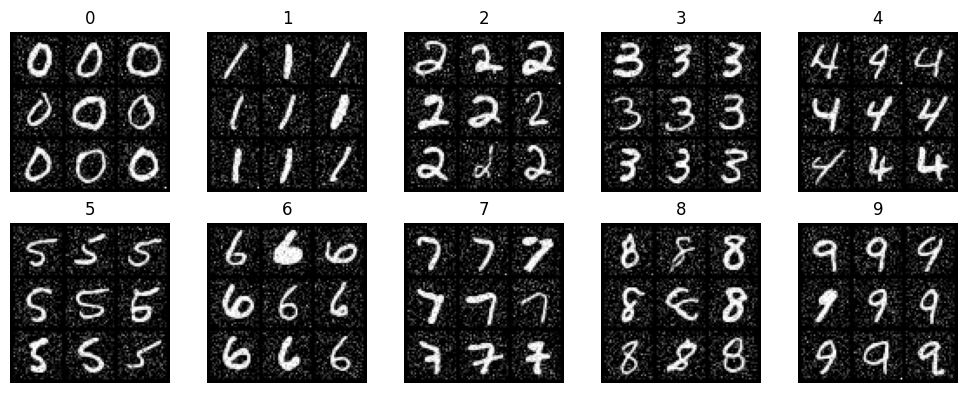

In [38]:
def Euler_Maruyama_sampler(score_model,
              marginal_prob_std,
              diffusion_coeff,
              num_steps,
              batch_size=64,
              x_shape=(1, 28, 28),
              device='cuda',
              eps=1e-3, y=None):
    """Generate samples from score-based models with the Euler-Maruyama solver.

    Args:
    score_model: A PyTorch model that represents the time-dependent score-based model.
    marginal_prob_std: A function that gives the standard deviation of
      the perturbation kernel.
    diffusion_coeff: A function that gives the diffusion coefficient of the SDE.
    batch_size: The number of samplers to generate by calling this function once.
    num_steps: The number of sampling steps.
      Equivalent to the number of discretized time steps.
    device: 'cuda' for running on GPUs, and 'cpu' for running on CPUs.
    eps: The smallest time step for numerical stability.

    Returns:
    Samples.
    """
    t = torch.ones(batch_size, device=device)
    init_x = torch.randn(batch_size, *x_shape, device=device) \
    * marginal_prob_std(t)[:, None, None, None]
    time_steps = torch.linspace(1., eps, num_steps, device=device)
    step_size = time_steps[0] - time_steps[1]
    x = init_x
    with torch.no_grad():
        for time_step in tqdm(time_steps):
            batch_time_step = torch.ones(batch_size, device=device) * time_step
            g = diffusion_coeff(batch_time_step)
            mean_x = x + (g**2)[:, None, None, None] * score_model(x, batch_time_step, y=y) * step_size
            x = mean_x + torch.sqrt(step_size) * g[:, None, None, None] * torch.randn_like(x)
    # Do not include any noise in the last sampling step.
    return mean_x
sigma =  25.0#@param {'type':'number'}

marginal_prob_std_fn = functools.partial(marginal_prob_std, sigma=sigma)
diffusion_coeff_fn = functools.partial(diffusion_coeff, sigma=sigma)

# Load the pre-trained checkpoint from disk.
device = 'cuda' #@param ['cuda', 'cpu'] {'type':'string'}
ckpt = torch.load('ckpt_700.pth', map_location=device)
score_model = torch.nn.DataParallel(UNet_Tranformer(marginal_prob_std=marginal_prob_std_fn))
score_model = score_model.to(device)
score_model.load_state_dict(ckpt)
score_model.eval()

# Set params
sample_batch_size = 9 #@param {'type':'integer'}
num_steps = 250 #@param {'type':'integer'}
sampler = Euler_Maruyama_sampler #@param ['Euler_Maruyama_sampler', 'pc_sampler', 'ode_sampler'] {'type': 'raw'}

## Generate samples using the specified sampler.
%matplotlib inline
plt.figure(figsize=(10, 4))

for i, digit in enumerate(range(10)):
    samples = sampler(score_model,
            marginal_prob_std_fn,
            diffusion_coeff_fn,
            num_steps,
            sample_batch_size,
            device=device,
            y=digit*torch.ones(sample_batch_size, dtype=torch.long))

    ## Sample visualization.
    samples = samples.clamp(0.0, 1.0)
    sample_grid = make_grid(samples, nrow=int(np.sqrt(sample_batch_size)))

    plt.subplot(2, 5, i+1)
    plt.title(f"{digit}")
    plt.axis('off')
    plt.imshow(sample_grid.permute(1, 2, 0).cpu(), vmin=0., vmax=1.)

plt.tight_layout()
plt.show()